In [358]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import cache
import math
from scipy.stats import kendalltau

In [359]:
type Node = int

In [360]:
DATASET_PATH = "../datasets/ca_hepth.txt"

In [361]:
df = pd.read_csv(DATASET_PATH, sep="\t", names=["source", "target"])

In [362]:
df.head()

,source,target
0,24325,24394
1,24325,40517
2,24325,58507
3,24394,3737
4,24394,3905


In [363]:
tiny_network = [
    [0,1,1,1,1,1,1],
    [1,0,0,0,1,0,0],
    [1,0,0,0,1,0,0],
    [1,0,0,0,1,1,0],
    [1,1,1,1,0,0,0],
    [1,0,0,1,0,0,0],
    [1,0,0,0,0,0,0],
]
tiny_network = nx.from_numpy_array(np.array(tiny_network))

In [364]:
vis_graph = nx.from_pandas_edgelist(df.head(120))
graph = nx.from_pandas_edgelist(df)
full_graph = nx.from_pandas_edgelist(df)

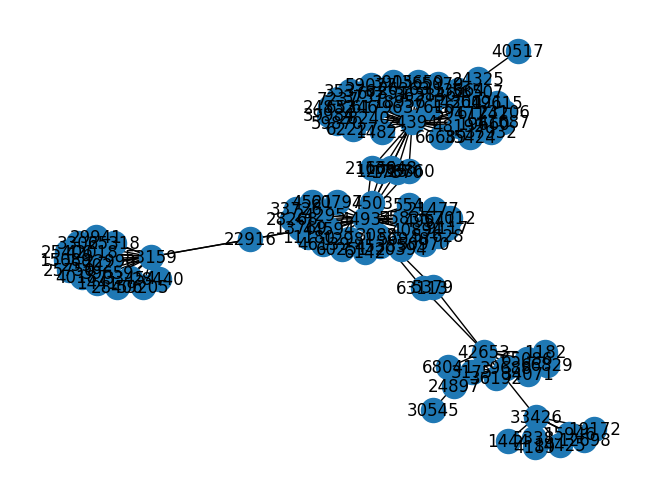

In [365]:
nx.draw(vis_graph, pos=nx.spring_layout(vis_graph, iterations=100, seed=1721), font_weight='light', with_labels=True)

In [366]:
@cache
def all_kshell_values(graph: nx.Graph) -> dict[Node, int]:
    return nx.core_number(graph)

def kshell(graph: nx.Graph, node: Node) -> int:
    return all_kshell_values(graph)[node]

@cache
def all_iteration_kshell_values(graph: nx.Graph) -> dict[Node, int]:
    iks = {}
    remaining_nodes = set(graph.nodes)
    k = 1

    while remaining_nodes:
        shell = [node for node in remaining_nodes if graph.degree(node) <= k]

        while shell:
            for node in shell:
                iks[node] = k
                graph.remove_node(node)

            remaining_nodes -= set(shell)
            shell = [node for node in remaining_nodes if graph.degree(node) <= k]

        k += 1

    return iks

def iter_kshell(graph: nx.Graph, node: Node) -> int:
    return all_iteration_kshell_values(graph)[node]

def max_iter_kshell(graph: nx.Graph) -> int:
    return max(all_iteration_kshell_values(graph).values())

def min_iter_kshell(graph: nx.Graph) -> int:
    return min(all_iteration_kshell_values(graph).values())

def max_kshell(graph: nx.Graph):
    return max(all_kshell_values(graph).values())

def min_kshell(graph: nx.Graph):
    return min(all_kshell_values(graph).values())


In [367]:
def gravity_centrality(graph: nx.Graph, node: Node) -> float:
    influence_radius = 3
    acc = 0
    neighbors = set()
    path_lengths = {}

    for i in graph.nodes:
        if i != node:
            try:
                distance = nx.shortest_path_length(graph, i, node)
                path_lengths[(i, node)] = distance
                path_lengths[(node, i)] = distance
            except nx.NetworkXNoPath:
                pass


    for i in graph.nodes:
        path_length = path_lengths.get((i, node))
        if i != node and path_length and path_lengths[(i, node)] <= influence_radius:
            neighbors.add(i)

    for neighbor in neighbors:
        num = kshell(graph, node) * kshell(graph, neighbor)
        distance = path_lengths[(neighbor, node)]
        acc = num / distance

    return acc

In [368]:
def grav_coeff(graph: nx.Graph, i: Node, j: Node) -> float:
    g = np.power(np.e, (iter_kshell(graph, i) - iter_kshell(graph, j)) / (max_iter_kshell(graph) - min_iter_kshell(graph)))
    return g

In [369]:
def gravitational_force(graph: nx.Graph, i: Node, j: Node) -> float:
    degree_prod = graph.degree(i) * graph.degree(j)
    distance = nx.shortest_path_length(graph, i, j)
    distance = 1 if distance == 0 else distance

    g = grav_coeff(graph, i, j)

    return g * degree_prod / np.square(distance)

In [370]:
def delta(graph: nx.Graph, i: Node, s: Node) -> float:
    power = (iter_kshell(graph, s) - iter_kshell(graph, i)) / (max_iter_kshell(graph) - min_iter_kshell(graph))
    return np.sqrt(np.pow(np.e, power))

In [371]:
def radius_of_influence(graph: nx.Graph, i: Node, s: Node, d: float | None) -> float | int:
    if d is None:
        d = delta(graph, i, s)

    try:
        distance = nx.shortest_path_length(graph, i, s)
    except nx.NetworkXNoPath:
        distance = 0
    degree_quotient = nx.degree(graph, s) / nx.degree(graph, i)

    return distance / (1 + (np.sqrt(degree_quotient) * d))


In [372]:
def calculate_ground_truth_influence(graph: nx.Graph) -> dict[int, int]:
    ground_truth = {}
    for node in graph.nodes():
        ground_truth[node] = nx.degree_centrality(graph)[node]
    return ground_truth


def kendall_tau_radius_decision(graph: nx.Graph, radius_map: dict[int, list[float]]) -> dict[int, float]:
    ground_truth = calculate_ground_truth_influence(graph)
    ground_truth_list = np.array(list(ground_truth.values()))

    best_tau = -1
    best_delta = None

    for delta in range(17 + 1 - 6):
        radius_list = map(lambda x: x[delta], radius_map.values())
        influence_values = np.array(list(radius_list))

        tau, _ = kendalltau(ground_truth_list, influence_values)

        if tau > best_tau:
            best_tau = tau
            best_delta = delta

    best_radius_list = list(map(lambda x: (x[0], x[1][best_delta]), radius_map.items()))
    best_radius_map = {}

    for node, radius in best_radius_list:
        best_radius_map[node] = radius

    return best_radius_map

In [373]:
def eigenvalue_decomposition(graph: nx.Graph) -> list[list[float]]:
    A = nx.to_numpy_array(graph)
    eigenvalues, eigenvectors = np.linalg.eig(A)

    D = np.diag(eigenvalues)

    Q = eigenvectors
    Q_inv = np.linalg.inv(Q)

    A = Q @ D @ Q_inv

    return A

In [374]:
def comm_network_matrix(graph: nx.Graph) -> list[list[float]]:
    try:
        diam = nx.diameter(graph)
    except nx.NetworkXError:
        diam = max([max(j.values()) for (i,j) in nx.shortest_path_length(graph)])

    A = eigenvalue_decomposition(graph)
    X = A

    for i in range(1, diam + 1):
        X += (1 / math.factorial(i)) * A

    return X

In [375]:
def normalized_comm_network_matrix(graph: nx.Graph) -> list[list[float]]:
    X = comm_network_matrix(graph)

    X_max = np.max(X)
    X_min = np.min(X)

    return (X - X_min) / (X_max - X_min)

In [376]:
def cagm_float(graph: nx.Graph, i: Node, radius: float, norm_comm_matrix: list[list[float]]) -> float:
    integer_radius = int(np.floor(radius))
    fractional_radius = radius - integer_radius
    cagm_value_floor = 0
    cagm_value_ceil = 1

    # Sum influence for neighbors within integer radius
    neighbors = nx.single_source_shortest_path_length(graph, i, cutoff=integer_radius).keys()
    for y in neighbors:
        if y != i:
            influence_probability = norm_comm_matrix[i][y]
            force = gravitational_force(graph.copy(), i, y)

            cagm_value_floor += influence_probability * (force + fractional_radius)

    # Add fractional influence for neighbors at ⌈R_i⌉
    fractional_neighbors = [v for k, v in nx.single_source_shortest_path_length(graph, i, cutoff=integer_radius + 1).items() if k == integer_radius + 1]
    for w in fractional_neighbors:
        influence_probability = norm_comm_matrix[i][w]
        force = gravitational_force(graph.copy(), i, w)
        cagm_value_ceil += influence_probability * force

    return cagm_value_floor * cagm_value_ceil

def cagm_int(graph: nx.Graph, i: Node, radius: float, norm_comm_matrix: list[list[float]]) -> float:
    radius = int(np.floor(radius))
    cagm_value = 0

    neighbors = nx.single_source_shortest_path_length(graph, i, cutoff=radius).keys()
    for y in neighbors:
        if y != i:
            influence_probability = norm_comm_matrix[i][y]
            force = gravitational_force(graph.copy(), i, y)

            cagm_value += influence_probability * force

    return cagm_value

In [377]:
def get_farthest_node(graph: nx.Graph, node: Node) -> Node:
    lengths = nx.single_source_shortest_path_length(graph, node)
    farthest_node = max(lengths, key=lengths.get)

    return farthest_node

In [378]:
def cagm_algo_ranking(graph: nx.Graph):
    radius_delta_map = {}
    for i in graph.nodes():
        radius_delta_map[i] = []

        s = get_farthest_node(graph, i)
        # s = i
        # while s == i:
        #     s = np.random.choice(graph.nodes())

        for delta in range(6, 17 + 1):
            delta = delta / 10

            radius = radius_of_influence(graph, i, s, delta)
            radius_delta_map[i].append(radius)

    radius_map = kendall_tau_radius_decision(graph, radius_delta_map)
    X = normalized_comm_network_matrix(graph.copy())

    for i in graph.nodes():
        radius = radius_map[i]

        # If integer
        cagm = None
        if radius % 1 == 0:
            cagm = cagm_int(graph.copy(), i, radius, X)
        else:
            cagm = cagm_float(graph.copy(), i, radius, X)

        print(f"CAGM(Node {i}): {cagm}")


In [379]:
cagm_algo_ranking(tiny_network)

CAGM(Node 0): 0.0
CAGM(Node 1): 20.499999999999986
CAGM(Node 2): 266.4999999999991
CAGM(Node 3): 37.02712145876341
CAGM(Node 4): 482.55242323504973
CAGM(Node 5): 18.499999999999996
CAGM(Node 6): 2.2892185225725297


In [380]:
G = nx.erdos_renyi_graph(20, 0.3)
cagm_algo_ranking(G)

CAGM(Node 0): 41.404356559953754
CAGM(Node 1): 254.05424291753184
CAGM(Node 2): 10985.465920490245
CAGM(Node 3): 242.98331582979566
CAGM(Node 4): 366.4852191756463
CAGM(Node 5): 22122.86160737041
CAGM(Node 6): 30.215958087858137
CAGM(Node 7): 30.07593652920054
CAGM(Node 8): 198.08136437629622
CAGM(Node 9): 240.0813643762954
CAGM(Node 10): 144.05104571286705
CAGM(Node 11): 331.63154280110615
CAGM(Node 12): 544.474973744693
CAGM(Node 13): 111.50000000000082
CAGM(Node 14): 7995.010481922687
CAGM(Node 15): 227.62999137843775
CAGM(Node 16): 248.05424291753093
CAGM(Node 17): 103.18210051091191
CAGM(Node 18): 30936.123555957438
CAGM(Node 19): 274.8687552614606


In [381]:
get_farthest_node(graph, 4306)

38832

In [382]:
cagm_algo_ranking(graph)